In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import keras
from keras.layers import LSTM, Dense, Activation
from keras.callbacks import EarlyStopping

data = sio.loadmat("Xtrain.mat")["Xtrain"]
print(data.shape)

Using TensorFlow backend.


(1000, 1)


In [2]:
# create a scaler and fit it on data
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data)

data_normed = scaler.transform(data)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


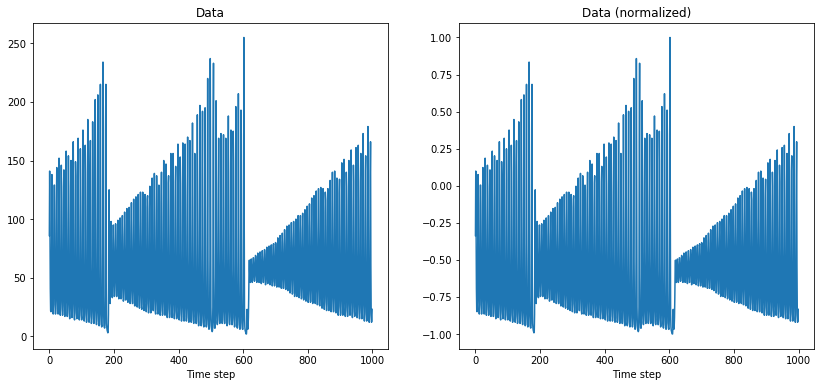

In [44]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(data)
plt.title("Data")
plt.xlabel("Time step")

plt.subplot(122)
plt.plot(data_normed)
plt.title("Data (normalized)")
plt.xlabel("Time step")
plt.show()

In [58]:
inputsize = 100

def evaluate_model(inp, target, epochs=1):
    # encode targets

    # define model
    model = keras.Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(inp.shape[1], 1), dropout=0.2, recurrent_dropout=0.2))
    model.add(LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['accuracy'])
    # fit model
    # model.fit(trainX, trainy_enc, epochs=50, verbose=0)
#     early_stopping_monitor = EarlyStopping(monitor='loss', patience=3)
    history = model.fit(inp, target, epochs=epochs, validation_split=0.1, verbose=2)
    # evaluate the model
    # _, test_acc = model.evaluate(testX, testY, verbose=0)
    return model, history

In [59]:
# Create train and test data (model is trained on sequence and should predict the next timestep)
targetIndex = np.array(range(inputsize, len(data)))
# print(targetIndex-100)
inputdata = np.array([data_normed[ind-inputsize:ind] for ind in targetIndex])
target = data_normed[targetIndex]

print(f'inputdata Shape {inputdata.shape}')
print(f'target Shape {target.shape}')

# Split into train and test
splitInd = int(len(inputdata)*0.9)
trainX = inputdata[:splitInd]
trainY = target[:splitInd]
testX = inputdata[splitInd:]
testY = target[splitInd:]
print("trainX.shape", trainX.shape)
print("trainY.shape", trainY.shape)
print("testX.shape", testX.shape)
print("testY.shape", testY.shape)

# model, history = evaluate_model(trainX, trainY, testX, testY, epochs=5)
model, history = evaluate_model(trainX, trainY, epochs=50)

# plt.plot(history.history['loss'])
# plt.show()


inputdata Shape (900, 100, 1)
target Shape (900, 1)
trainX.shape (810, 100, 1)
trainY.shape (810, 1)
testX.shape (90, 100, 1)
testY.shape (90, 1)
Train on 729 samples, validate on 81 samples
Epoch 1/50
 - 9s - loss: 0.2228 - acc: 0.0014 - val_loss: 0.1220 - val_acc: 0.0000e+00
Epoch 2/50
 - 2s - loss: 0.1586 - acc: 0.0027 - val_loss: 0.1046 - val_acc: 0.0000e+00
Epoch 3/50
 - 2s - loss: 0.1489 - acc: 0.0014 - val_loss: 0.1036 - val_acc: 0.0000e+00
Epoch 4/50
 - 2s - loss: 0.1412 - acc: 0.0027 - val_loss: 0.1034 - val_acc: 0.0000e+00
Epoch 5/50
 - 2s - loss: 0.1397 - acc: 0.0027 - val_loss: 0.1007 - val_acc: 0.0000e+00
Epoch 6/50
 - 2s - loss: 0.1395 - acc: 0.0000e+00 - val_loss: 0.1016 - val_acc: 0.0000e+00
Epoch 7/50
 - 2s - loss: 0.1376 - acc: 0.0027 - val_loss: 0.1048 - val_acc: 0.0000e+00
Epoch 8/50
 - 2s - loss: 0.1376 - acc: 0.0027 - val_loss: 0.0995 - val_acc: 0.0000e+00
Epoch 9/50
 - 2s - loss: 0.1365 - acc: 0.0000e+00 - val_loss: 0.0985 - val_acc: 0.0000e+00
Epoch 10/50
 - 2s 

90/90 [==============================] - 0s 665us/step
[0.00294898199952311, 0.0]
pred.shape  (90, 1)


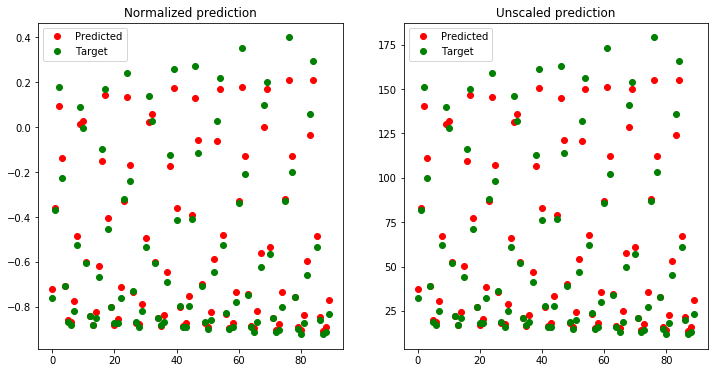

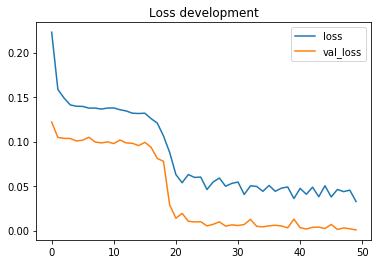

In [66]:
pred = model.predict(testX)
pred_unscaled = scaler.inverse_transform(pred)
testY_unscaled = scaler.inverse_transform(testY)
print("pred.shape ", pred.shape)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Normalized prediction')
plt.plot(pred, 'o', c='r', label="Predicted")
plt.plot(testY, 'o', c='g', label="Target")
plt.legend()

plt.subplot(122)
plt.title('Unscaled prediction')
plt.plot(pred_unscaled, 'o', c='r', label="Predicted")
plt.plot(testY_unscaled, 'o', c='g', label="Target")
plt.legend()
plt.show()

plt.title('Loss development')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()